In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from config import Conf
import os

In [ ]:
print(Conf.trial_len)

In [ ]:
iter = 1000
fname = 'data_' + str(iter) + '.npz'
# fname = 'data_all.npz'
# fpath = os.path.join(Conf.save_dir, fname)
fpath = os.path.join('../run_data', fname)
print(fpath)
data = np.load(fpath)
inputs, targets, choices, ground_truth, p_A, hiddens, accs = data.values()

In [ ]:
hiddens.shape

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

b = 0
trials = 200
t = Conf.trial_len * trials
sf = 1.1

fig, axes = plt.subplots(1,6, figsize=(sf*4, sf*t//20), dpi=200)
axes[0].imshow(inputs[b, :t, :], vmin=0, vmax=1, aspect='auto')
axes[0].set_title('Input', fontsize=8)
axes[0].set_ylabel('Trial #')
axes[1].imshow(ground_truth[b, :t, :], vmin=0, vmax=1, aspect='auto')
axes[1].set_title('Ground truth', fontsize=8)
axes[2].imshow(targets[b, :t, :], vmin=0, vmax=1, aspect='auto')
axes[2].set_title('Target', fontsize=8)
axes[3].imshow(choices[b, :t, :], vmin=0, vmax=1, aspect='auto')
axes[3].set_title('Softmax', fontsize=8)

# # Draw white lines every 4 rows
# for i in range(1, choices[b, :t, :].shape[0] // 4):
#     axes[0].axhline(y=i * 4 - 0.5, color='white', linewidth=2)
#     axes[1].axhline(y=i * 4 - 0.5, color='white', linewidth=2)
#     axes[2].axhline(y=i * 4 - 0.5, color='white', linewidth=2)

# Set yticks at every 4th row and enable gridlines only for those ticks
for i, ax in enumerate(axes):
    if i == len(axes)-1:
        start, gap, rows = 0.5, 1, trials
        ax.set_xticks(np.arange(0.5, Conf.trial_len, 1))
        ax.xaxis.grid(True, linestyle='-', color='white', linewidth=1)
    else:
        start, gap, rows = Conf.trial_len-0.5, Conf.trial_len, t
        ax.xaxis.grid(False)
    # Generate ytick locations, starting from 3.5 (since we want lines between blocks of 4)
    yticks = np.arange(start, rows, gap)
    ax.set_yticks(yticks)

    # Enable grid only for y-axis
    ax.yaxis.grid(True, linestyle='-', color='white', linewidth=2)

    # Optional: Hide x-axis grid lines
# Get the column indices of the largest value in each row of choices
max_choices = np.argmax(choices[b, :t, :], axis=1)
max_targets = np.argmax(targets[b, :t, :], axis=1)

# Iterate through each row and draw a red box around the cell with the largest value
for i, (choice, target) in enumerate(zip(max_choices, max_targets)):
    c = 'green' if choice==target else 'red'
    rect = patches.Rectangle((choice-0.5, i-0.5), 1, 1, linewidth=1.5, edgecolor=c, facecolor='none')
    axes[3].add_patch(rect)

correct = (np.argmax(choices, axis=-1) == np.argmax(targets, axis=-1)).reshape((choices.shape[0], choices.shape[1]//Conf.trial_len, Conf.trial_len))
# axes[3].imshow(correct[b, :trials, :], aspect='auto')
axes[4].set_title('Correct', fontsize=8)
# Create a color matrix with the same shape as your correct/incorrect matrix
# Initialize it fully transparent
color_matrix = np.zeros((*correct[b, :trials, :].shape, 4))

# Set red color with alpha=0.5 for cells with 0
color_matrix[correct[b, :trials, :] == 0] = [1, 0, 0, 0.3]  # Red with alpha 0.5

# Set green color with alpha=0.5 for cells with 1
color_matrix[correct[b, :trials, :] == 1] = [0, 1, 0, 0.3]  # Green with alpha 0.5

# Now identify rows where all values are 1 and set alpha=1.0 for those cells
all_correct_rows = np.all(correct[b, :trials, :] == 1, axis=1)
color_matrix[all_correct_rows, :, 3] = 1.0  # Set alpha to 1.0 for these rows

# Display the color matrix using imshow
axes[4].imshow(color_matrix, aspect='auto')
axes[4].set_xticks(np.arange(0.5, Conf.trial_len-0.5, 1))
axes[4].set_yticks(np.arange(0.5, trials-0.5, 1))
axes[4].grid(True, linestyle='-', color='white', linewidth=1)
# q: how do I turn on grid on this axis
# a: 

for ax in axes:
    ax.set_yticklabels([])
    ax.set_xticklabels([])

axes[5].plot(p_A[b, :trials], 0.5 + np.arange(trials), marker='o', markersize=3, color='b')
axes[5].set_ylim([0, trials])
axes[5].set_xlim([0, 1])
axes[5].invert_yaxis()
axes[5].axvline(x=0.5, color='red', linestyle='--', linewidth=1)
axes[5].set_title('p(A)', fontsize=8)
# q: how do I plot this vertically, so that the x axis and y axis are swapped?
# 

proportion_correct = 100 * np.sum(correct, axis=(0,1)) / (correct.shape[0]*correct.shape[1])
proportion_correct = ', '.join([f'{p:.1f}' for p in proportion_correct])
print(proportion_correct)
# Set the suptitle of the figure with the calculated proportion
fig.suptitle('Accs: ' + proportion_correct)

plt.tight_layout(rect=[0, 0, 1, 0.985]) # Adjust layout to make space for suptitle
plt.show()

fig.savefig(os.path.join(Conf.save_dir, 'panel.png'))


In [ ]:
b=0
choice_hiddens = hiddens[b, :, :][:100, :]
lims = np.max(np.abs(choice_hiddens))
plt.figure(figsize=(10, 10))
plt.imshow(choice_hiddens, vmin=0, vmax=lims)
plt.colorbar()


In [ ]:
choice_hiddens = hiddens[:, ::5, 103][:, :200].T
plt.figure(figsize=(10, 10))
plt.imshow(choice_hiddens)
plt.xlabel('batch')

In [ ]:
import torch
import seaborn as sns

cmap=sns.color_palette("icefire", as_cmap=True)

iter = 8000
state_dict = torch.load('../run_data_1_128_1e5/weights_' + str(iter) + '.pth')
# state_dict = torch.load('../model_weights.pth')
print(state_dict.keys())
w = state_dict['rnn.h2h.weight'].numpy()
lims = np.max(np.abs(w))

plt.figure(figsize=(10,10))
plt.imshow(w, cmap=cmap, vmin=-lims, vmax=lims)
plt.xlabel('pre-synaptic')
plt.ylabel('post-synaptic')
plt.colorbar()

In [ ]:
# iter = 12000
# fname = 'data_' + str(iter) + '.npz'
# # fpath = os.path.join(Conf.save_dir, fname)
# fpath = os.path.join('../run_data_1_128_1e5', fname)

iter = 90000
fname = 'data_' + str(iter) + '.npz'
# fpath = os.path.join(Conf.save_dir, fname)
fpath = os.path.join('../run_data_08_256_1e8', fname)
print(fpath)
data = np.load(fpath)
inputs, targets, choices, ground_truth, p_A, hiddens, accs = data.values()

In [ ]:
batch = 0
T = hiddens.shape[1]
n_neurons = hiddens.shape[-1]

ab = np.argmax(choices[batch, Conf.trial_len-1::Conf.trial_len, :], axis=-1)
a, b = np.unique(ab)

a_trials_idx = np.where(ab==a)[0]
b_trials_idx = np.where(ab==b)[0]

print(a_trials_idx[:20])
print(b_trials_idx[:20])
print(ab[a_trials_idx[:20]])
print(ab[b_trials_idx[:20]])

hiddens_trials = np.array_split(hiddens[batch, :, :], T//Conf.trial_len, axis=0)
print(hiddens_trials[0].shape, len(hiddens_trials))
hiddens_trials = np.stack(hiddens_trials, axis=0)
# q: how do I join a list of arrays along a new axis?
# a: np.concatenate(hiddens_trials, axis=1)
print(hiddens_trials.shape)

a_trials = hiddens_trials[a_trials_idx, :, :]
a_trials_mean = np.mean(a_trials, axis=0)
a_trials_std = np.std(a_trials, axis=0)

b_trials = hiddens_trials[b_trials_idx, :, :]
b_trials_mean = np.mean(b_trials, axis=0)
b_trials_std = np.std(b_trials, axis=0)

fig, axes = plt.subplots(16, n_neurons//16, figsize=(2*16, 2*n_neurons//16))
for i, ax in enumerate(axes.flatten()):
    mean = a_trials_mean[:, i]
    lower = mean - a_trials_std[:, i]
    upper = mean + a_trials_std[:, i]
    ax.plot(a_trials_mean[:, i], color='blue')
    ax.fill_between(np.arange(Conf.trial_len), lower, upper, color='blue', alpha=0.2, edgecolor=None)

    mean = b_trials_mean[:, i]
    lower = mean - b_trials_std[:, i]
    upper = mean + b_trials_std[:, i]
    ax.plot(b_trials_mean[:, i], color='red')
    ax.fill_between(np.arange(Conf.trial_len), lower, upper, color='red', alpha=0.2, edgecolor=None)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.set_ticks_position('none')
    ax.set_ylim(bottom=0)

# q: how do I set only the lower y lim?
# a:
# axes[0].imshow(a_trials_mean.T, aspect='auto')
# axes[1].imshow(b_trials_mean.T, aspect='auto')
# axes[2].imshow(a_trials_mean.T - b_trials_mean.T, aspect='auto')
plt.tight_layout()


In [ ]:
batch = 2
T = hiddens.shape[1]
n_neurons = hiddens.shape[-1]

ab = np.argmax(choices[batch, Conf.trial_len-1::Conf.trial_len, :], axis=-1)
a, b = np.unique(ab)

a_trials_idx = np.where(ab==a)[0]
b_trials_idx = np.where(ab==b)[0]

print(a_trials_idx[:20])
print(b_trials_idx[:20])
print(ab[a_trials_idx[:20]])
print(ab[b_trials_idx[:20]])

hiddens_trials = np.array_split(hiddens[batch, :, :], T//Conf.trial_len, axis=0)
print(hiddens_trials[0].shape, len(hiddens_trials))
hiddens_trials = np.stack(hiddens_trials, axis=0)
# q: how do I join a list of arrays along a new axis?
# a: np.concatenate(hiddens_trials, axis=1)
print(hiddens_trials.shape)

a_trials = hiddens_trials[a_trials_idx, :, :]
a_trials_mean = np.mean(a_trials, axis=0)
a_trials_std = np.std(a_trials, axis=0)

b_trials = hiddens_trials[b_trials_idx, :, :]
b_trials_mean = np.mean(b_trials, axis=0)
b_trials_std = np.std(b_trials, axis=0)

fig, axes = plt.subplots(16, n_neurons//16, figsize=(16, 2*n_neurons//16))
for i, ax in enumerate(axes.flatten()):
    mean = a_trials_mean[:, i]
    lower = mean - a_trials_std[:, i]
    upper = mean + a_trials_std[:, i]
    ax.plot(a_trials_mean[:, i], color='blue')
    ax.fill_between(np.arange(Conf.trial_len), lower, upper, color='blue', alpha=0.2, edgecolor=None)

    mean = b_trials_mean[:, i]
    lower = mean - b_trials_std[:, i]
    upper = mean + b_trials_std[:, i]
    ax.plot(b_trials_mean[:, i], color='red')
    ax.fill_between(np.arange(Conf.trial_len), lower, upper, color='red', alpha=0.2, edgecolor=None)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.set_ticks_position('none')
    ax.set_ylim(bottom=0)

# q: how do I set only the lower y lim?
# a:
# axes[0].imshow(a_trials_mean.T, aspect='auto')
# axes[1].imshow(b_trials_mean.T, aspect='auto')
# axes[2].imshow(a_trials_mean.T - b_trials_mean.T, aspect='auto')
plt.tight_layout()


In [ ]:
choices_arg = np.argmax(choices, axis=-1)
choices_arg_trial = np.array_split(choices_arg, choices_arg.shape[-1]//Conf.trial_len, axis=-1)
choices_arg_trial = np.stack(choices_arg_trial, axis=1)
 
hidden_trial = np.array_split(hiddens, hiddens.shape[-2]//Conf.trial_len, axis=-2)
hidden_trial = np.stack(hidden_trial, axis=1)

print(choices_arg_trial.shape)
print(hidden_trial.shape)

print(choices_arg.shape)
print(choices_arg[0, :20])

means_choice, stds_choice = [], []
for port_id in range(9):
    idxs = np.where(choices_arg_trial[:, :, -1] == port_id)
    # print(idxs)

    choices_arg_trial[idxs[0], idxs[1], :]
    h = hidden_trial[idxs[0], idxs[1], :]
    h_mean = np.mean(h, axis=0)
    h_std = np.std(h, axis=0)
    means_choice.append(h_mean)
    stds_choice.append(h_std)
    # print(h_mean.shape)

fig, axes = plt.subplots(16, n_neurons//16, figsize=(2*n_neurons//16, 16))
for i, ax in enumerate(axes.flatten()):
    vmax = 0
    for h_mean, h_std in zip(means_choice, stds_choice):
        mean = h_mean[:, i]
        vmax = np.maximum(vmax, max(mean))
        lower = mean - h_std[:, i]
        upper = mean + h_std[:, i]
        ax.plot(mean)
        
        # ax.fill_between(np.arange(Conf.trial_len), lower, upper, alpha=0.2, edgecolor=None)
        
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.set_ticks_position('none')
    ax.set_ylim(bottom=0, top=vmax)

# q: how do I set only the lower y lim?
# a:
# axes[0].imshow(a_trials_mean.T, aspect='auto')
# axes[1].imshow(b_trials_mean.T, aspect='auto')
# axes[2].imshow(a_trials_mean.T - b_trials_mean.T, aspect='auto')
plt.tight_layout()



In [ ]:
T = choices.shape[1]
choices_arg = np.argmax(choices, axis=-1)

i = 3
add_on = i % Conf.trial_len
choices_arg = choices_arg[:, i:T-Conf.trial_len+add_on]
# print(choices_arg.shape)
print(choices_arg[0,:20])
choices_arg_trial = np.array_split(choices_arg, choices_arg.shape[-1]//Conf.trial_len, axis=-1)
choices_arg_trial = np.stack(choices_arg_trial, axis=1)
# print(choices_arg_trial.shape)
print(choices_arg_trial[0, 0, :])
print(choices_arg[0, :20])

hidden_trial = hiddens[:, i:T-Conf.trial_len+add_on, :]
hidden_trial = np.array_split(hidden_trial, hidden_trial.shape[-2]//Conf.trial_len, axis=-2)
hidden_trial = np.stack(hidden_trial, axis=1)

print(choices_arg_trial.shape)
print(hidden_trial.shape)

print(choices_arg.shape)

means_init, stds_init = [], []
for port_id in range(9):
    idxs = np.where(choices_arg_trial[:, :, -1] == port_id)
    # print(idxs)

    choices_arg_trial[idxs[0], idxs[1], :]
    h = hidden_trial[idxs[0], idxs[1], :]
    h_mean = np.mean(h, axis=0)
    h_std = np.std(h, axis=0)
    means_init.append(h_mean)
    stds_init.append(h_std)
    # print(h_mean.shape)

fig, axes = plt.subplots(16, n_neurons//16, figsize=(2*n_neurons//16, 16))
for i, ax in enumerate(axes.flatten()):
    vmax = 0
    for h_mean, h_std in zip(means_init, stds_init):
        mean = h_mean[:, i]
        vmax = np.maximum(vmax, max(mean))
        lower = mean - h_std[:, i]
        upper = mean + h_std[:, i]
        ax.plot(mean)
        
        # ax.fill_between(np.arange(Conf.trial_len), lower, upper, alpha=0.2, edgecolor=None)
        
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.set_ticks_position('none')
    ax.set_ylim(bottom=0, top=vmax)

# q: how do I set only the lower y lim?
# a:
# axes[0].imshow(a_trials_mean.T, aspect='auto')
# axes[1].imshow(b_trials_mean.T, aspect='auto')
# axes[2].imshow(a_trials_mean.T - b_trials_mean.T, aspect='auto')
plt.tight_layout()

In [ ]:
k = 10
fig, axes = plt.subplots(k, 2, figsize=(4,k))

for i in range(k):
    vmax = 0
    for h_mean, h_std in zip(means_init, stds_init):
        mean = h_mean[:, i]
        vmax = np.maximum(vmax, max(mean))
        lower = mean - h_std[:, i]
        upper = mean + h_std[:, i]
        axes[i,0].plot(mean)
        axes[i,0].set_xticks(np.arange(Conf.trial_len), ['', 'choice', '', '', 'init'], fontsize=8)

    for h_mean, h_std in zip(means_choice, stds_choice):
        mean = h_mean[:, i]
        vmax = np.maximum(vmax, max(mean))
        lower = mean - h_std[:, i]
        upper = mean + h_std[:, i]
        axes[i,1].plot(mean)
        axes[i,1].set_xticks(np.arange(Conf.trial_len), ['', '', 'init', '', 'choice'], fontsize=8)
        
        # ax.fill_between(np.arange(Conf.trial_len), lower, upper, alpha=0.2, edgecolor=None)
        
    axes[i, 0].spines['right'].set_visible(False)
    axes[i, 0].spines['top'].set_visible(False)
    # axes[i, 0].xaxis.set_ticks_position('none')
    axes[i, 0].set_ylim(bottom=0, top=vmax)
    axes[i, 1].spines['right'].set_visible(False)
    axes[i, 1].spines['top'].set_visible(False)
    # axes[i, 0].xaxis.set_ticks_position('none')
    axes[i, 1].set_ylim(bottom=0, top=vmax)
    plt.tight_layout()

In [ ]:
np.linspace(0, 2*np.pi, Conf.trial_len, endpoint=False)

In [ ]:
# Creating polar plots
k = 64
fig, axes = plt.subplots(k, 2, figsize=(4, 2*k), subplot_kw={'projection': 'polar'})
polar = True

theta = np.linspace(0, 2*np.pi, Conf.trial_len, endpoint=False)
theta = np.append(theta, theta[0])
rotation_angle = (2*np.pi / Conf.trial_len) + np.pi/2

for i in range(k):
    vmax = 0

    for port, (h_mean, h_std) in enumerate(zip(means_init, stds_init)):
        mean = h_mean[:, i]
        vmax = np.maximum(vmax, max(mean))

        mean = np.append(mean, mean[0])

        axes[i, 0].set_theta_offset(rotation_angle)
        axes[i, 0].plot(theta, mean, label=port if i==0 else None)
        axes[i, 0].set_xticks(np.linspace(0, 2*np.pi, Conf.trial_len, endpoint=False), ['delay', 'choice', 'rew', 'ITI', 'init'], fontsize=8)
        axes[i, 0].tick_params(axis='x', pad=-2 if polar else 0)  # Adjust pad value as needed

    for port, (h_mean, h_std) in enumerate(zip(means_choice, stds_choice)):
        mean = h_mean[:, i]
        vmax = np.maximum(vmax, max(mean))

        mean = np.append(mean, mean[0])
        axes[i, 1].set_theta_offset(rotation_angle)
        axes[i, 1].plot(theta, mean)
        axes[i, 1].set_xticks(np.linspace(0, 2*np.pi, Conf.trial_len, endpoint=False), ['rew', 'ITI', 'init', 'delay', 'choice'], fontsize=8)
        axes[i, 1].tick_params(axis='x', pad=-2 if polar else 0)  # Adjust pad value as needed

    axes[i, 0].set_ylim(bottom=0, top=vmax)
    axes[i, 1].set_ylim(bottom=0, top=vmax)
    axes[i, 0].set_yticks([])
    axes[i, 1].set_yticks([])

# Create a legend above the subplots
fig.legend(loc='lower center', bbox_to_anchor=(0.5, 1), ncol=3)  # Adjust ncol as per the number of labels

# Adjust layout to accommodate the legend
plt.tight_layout(rect=[0, 0, 1, 0.99])
# plt.tight_layout()

# Display the polar plots
plt.show()
plt.savefig(os.path.join(Conf.save_dir, 'init_choice.png'))

In [ ]:
from tqdm import tqdm
from matplotlib.lines import Line2D

choices_arg = np.argmax(choices, axis=-1)
choices_arg_trial = np.array_split(choices_arg, choices_arg.shape[-1]//Conf.trial_len, axis=-1)
choices_arg_trial = np.stack(choices_arg_trial, axis=1)

targets_arg = np.argmax(targets, axis=-1)
targets_arg_trial = np.array_split(targets_arg, targets_arg.shape[-1]//Conf.trial_len, axis=-1)
targets_arg_trial = np.stack(targets_arg_trial, axis=1)
 
hidden_trial = np.array_split(hiddens, hiddens.shape[-2]//Conf.trial_len, axis=-2)
hidden_trial = np.stack(hidden_trial, axis=1)

n_batches = 504
n_neurons = 2
neur_ids = range(np.minimum(n_neurons, hiddens.shape[-1]))
polar = True
separate_figures = True
overwrite = True
# load_dir = '../run_data_1_128_l2_1e6_l2_3e4'

subplot_kw={'projection': 'polar'} if polar else None

if not separate_figures:
    # Adjusting figure size based on the number of batches and neurons
    fig_width = max(10, n_batches)  # Adjust width as needed
    fig_height = max(20, n_neurons)  # Adjust height as needed
    fig, axes = plt.subplots(n_neurons, n_batches, figsize=(fig_width, fig_height),
                            subplot_kw=subplot_kw, layout='constrained')
else:
    n_col = Conf.port_dim - 1
    # n_row = int(np.ceil((n_batches) / (n_col-2))) + n_batches // (n_col-2)
    n_row = Conf.port_dim ** 2
    # Adjusting figure size based on the number of batches and neurons
    fig_width = 16  # Adjust width as needed
    fig_height = max(2, 2*n_row)  # Adjust height as needed
    save_dir = os.path.join(load_dir, 'separate_figs', 'polar' if polar else 'planar')
    print(save_dir)
    if not os.path.exists(save_dir): os.makedirs(save_dir)

theta = np.linspace(0, 2*np.pi, Conf.trial_len, endpoint=False)
if polar:
    theta = np.append(theta, theta[0])
rotation_angle = (2*np.pi / Conf.trial_len)/2 - np.pi/2

# a_trial_confirmed = np.argmax(p_A, axis=1)
# b_trial_confirmed = np.argmin(p_A, axis=1)
# a_ports = targets_arg_trial[np.arange(len(a_trial_confirmed)), a_trial_confirmed, -1]
# b_ports = targets_arg_trial[np.arange(len(b_trial_confirmed)), b_trial_confirmed, -1]
i_ports = np.argmax(inputs[:,:,:Conf.port_dim], axis=-1)[:, Conf.trial_len-3]
a_ports = np.argmax(inputs[:,:,:Conf.port_dim], axis=-1)[:, Conf.trial_len-2]
b_ports = np.argmax(inputs[:,:,:Conf.port_dim], axis=-1)[:, Conf.trial_len-1]

for k in tqdm(neur_ids):
    vmax = np.minimum(Conf.threshold, np.mean(hiddens[:, 5*Conf.trial_len:, k]) + 2 * np.std(hiddens[:, 5*Conf.trial_len:, k]))

    if separate_figures:
        fpath = os.path.join(save_dir, str(k) + '.png')
        if not overwrite and os.path.exists(fpath):
            print(f'file {fpath} already exists')
            continue
        fig, axes = plt.subplots(n_row, n_col+1, figsize=(fig_width, fig_height), subplot_kw=subplot_kw, layout='constrained')
        for ax in axes.flatten():
            ax.set_visible(False)
        # Draw horizontal lines across the figure
        for i in range(1, n_row // Conf.port_dim):
            # Calculate the y position in figure coordinates
            line_y = (n_row - i * Conf.port_dim) / n_row
            # Create a line at the desired y position that spans the width of the figure
            line = Line2D([0, 1], [line_y, line_y], transform=fig.transFigure, color="black", linewidth=2)
            fig.add_artist(line)

    for batch in range(np.minimum(n_batches, hiddens.shape[0])):
        vmax_ = np.max(hiddens[batch, 5*Conf.trial_len:, k])
        a_idx = np.where(choices_arg_trial[batch, :, -1] == a_ports[batch])[0]
        b_idx = np.where(choices_arg_trial[batch, :, -1] == b_ports[batch])[0]
        perm = (i_ports[batch], a_ports[batch], b_ports[batch])
        
        a_seq = choices_arg_trial[batch, a_idx[0], :]
        b_seq = choices_arg_trial[batch, b_idx[0], :]
        labels = [str(a_lab) if a_lab == b_lab else str(a_lab) + '/' + str(b_lab) for a_lab, b_lab in zip(a_seq, b_seq)]
    
        if not separate_figures:
            ax = axes[k, batch]
        else:
            ver_idx, hor_idx = perm[0]*(Conf.port_dim) + perm[1], perm[2]
            if ver_idx >= axes.shape[0] or hor_idx >= axes.shape[1]:
                continue
            ax = axes[ver_idx, hor_idx] #axes.flatten()[batch]
            ax.set_visible(True)

        h = hidden_trial[batch, :, :, k]
        h_a = h[a_idx, :]
        h_b = h[b_idx, :]
        h_a_mean = np.mean(h_a, axis=0)
        h_b_mean = np.mean(h_b, axis=0)

        if polar:
            h_a_mean = np.append(h_a_mean, h_a_mean[0])
            h_b_mean = np.append(h_b_mean, h_b_mean[0])
            ax.set_theta_offset(rotation_angle)
        else:
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)        
        
        ax.plot(theta, h_a_mean, color='blue', linewidth=1)
        ax.plot(theta, h_b_mean, color='red', linewidth=1, linestyle='--')
        ax.set_xticks(theta[:-1] if polar else theta, labels)
        ax.tick_params(axis='x', pad=-4 if polar else 0)  # Adjust pad value as needed
        # ax.set_xticklabels(a_seq.astype(str).tolist(), fontsize=6, pad=-15)  # Adjust pad as needed
        ax.set_yticklabels([])  # Remove y-ticks
        ax.set_ylim([0, np.maximum(vmax, 0.1)])
        if batch == 0 and not separate_figures:
            ax.set_ylabel(f'Neuron {k}', labelpad=20, fontsize=12)
        if k == 0 or separate_figures:
            # ax.set_title(f'Layout {batch}', fontsize=12)
            ax.set_title(f'{perm[0]}, {perm[1]}/{perm[2]}', fontsize=12, fontweight='bold')
        ax.set_xlabel(f'{vmax:.2f} ({vmax_:.2f})', labelpad=20 if polar else 5, fontsize=10)
        ax.xaxis.set_label_position('top')

    if separate_figures:
        fig.savefig(fpath)
        plt.close()
else:
    fig.savefig(os.path.join(load_dir, 'polar.png' if polar else 'planar.png'))
    plt.show()
        


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from config import Conf
import os

iter = 90000
# fname = 'data_' + str(iter) + '.npz'
# fpath = os.path.join(Conf.save_dir, fname)
fname = 'data_all.npz'
load_dir = '../run_data_08_256_l2_1e6_l2_3e4'
# load_dir = '../run_data'
fpath = os.path.join(load_dir, fname)
# fpath = os.path.join('../run_data/data_all.npz')
print(fpath)
data = np.load(fpath)
inputs, targets, choices, ground_truth, p_A, hiddens, accs = data.values()

../run_data_08_256_l2_1e6_l2_3e4/data_all.npz


In [32]:
# Open the HDF5 file
import h5py

def list_all_datasets(h5file, prefix=''):
    print('here')
    print([k for k in h5file.keys()])
    for key in h5file.keys():
        item = h5file[key]
        path = f"{prefix}/{key}"
        if isinstance(item, h5py.Dataset):
            # This is a dataset
            print(f"Dataset: {path}")
        elif isinstance(item, h5py.Group):
            # This is a group, recurse into it
            list_all_datasets(item, path)

with h5py.File(os.path.join(load_dir, 'data.h5'), 'r') as file:
    # Access the dataset
    list_all_datasets(file)
    dataset = file['inputs']

    # Determine chunk size
    chunk_size = 5000  
    # Read and process in chunks
    total_size = dataset.shape[1]
    print(total_size)
    for i in range(0, total_size, chunk_size):
        # Read a chunk
        chunk = dataset[:, i:i + chunk_size, :]

        # Process the chunk (example)
        print(chunk.shape) 

here
['choices', 'ground_truth', 'hidden', 'inputs', 'p_A_high', 'targets']
Dataset: /choices
Dataset: /ground_truth
Dataset: /hidden
Dataset: /inputs
Dataset: /p_A_high
Dataset: /targets
15000
(504, 5000, 21)
(504, 5000, 21)
(504, 5000, 21)


In [3]:
# batch = 0
# n_p_bins = 2
# cmap = cm.get_cmap('cool', n_p_bins) if n_p_bins > 2 else cm.get_cmap('bwr', n_p_bins) # Get a colormap object
# bin_edges = np.linspace(1, 0, n_p_bins+1)  # Creates 5 edges for 4 bins
# print(bin_edges)
# bins = np.digitize(p_A[batch, :], bin_edges) - 1
# plt.figure()
# for i in range(n_p_bins):
#     bin_idxs = np.where(bins == i)[0]
#     plt.plot(bin_idxs, p_A[batch, bin_idxs], c=cmap(i), label=f'[{bin_edges[i]:.2f} - {bin_edges[i+1]:.2f}]')
# plt.ylabel('p(A)')
# plt.legend()
# # 

In [10]:
from tqdm import tqdm
from matplotlib.lines import Line2D
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

choices_arg = np.argmax(choices, axis=-1)
choices_arg_trial = np.array_split(choices_arg, choices_arg.shape[-1]//Conf.trial_len, axis=-1)
choices_arg_trial = np.stack(choices_arg_trial, axis=1)

targets_arg = np.argmax(targets, axis=-1)
targets_arg_trial = np.array_split(targets_arg, targets_arg.shape[-1]//Conf.trial_len, axis=-1)
targets_arg_trial = np.stack(targets_arg_trial, axis=1)

inputs_arg = np.argmax(inputs, axis=-1)
inputs_arg_trial = np.array_split(inputs_arg, inputs_arg.shape[-1]//Conf.trial_len, axis=-1)
inputs_arg_trial = np.stack(inputs_arg_trial, axis=1)
 
hidden_trial = np.array_split(hiddens, hiddens.shape[-2]//Conf.trial_len, axis=-2)
hidden_trial = np.stack(hidden_trial, axis=1)

thresholds = 4.99
anomaly = hidden_trial > thresholds
anomalous_batches = np.any(anomaly, axis=(1,2,3))

print(np.where(anomalous_batches)[0])

[189 366]


In [11]:
n_batches = 504
n_neurons = 256
n_p_bins = 8
# neur_ids = range(np.minimum(n_neurons, hiddens.shape[-1]))
neur_ids = [39]
polar = True
separate_figures = True
overwrite = True
# load_dir = '../run_data_1_128_l2_1e6_l2_3e4'

subplot_kw={'projection': 'polar'} if polar else None

bin_edges = np.linspace(1, 0, n_p_bins+1)  # Creates 5 edges for 4 bins
cmap = cm.get_cmap('cool', n_p_bins) if n_p_bins > 2 else cm.get_cmap('bwr', n_p_bins) # Get a colormap object

if not separate_figures:
    # Adjusting figure size based on the number of batches and neurons
    fig_width = max(10, n_batches)  # Adjust width as needed
    fig_height = max(20, n_neurons)  # Adjust height as needed
    fig, axes = plt.subplots(n_neurons, n_batches, figsize=(fig_width, fig_height),
                            subplot_kw=subplot_kw, layout='constrained')
else:
    n_col = Conf.port_dim - 1
    # n_row = int(np.ceil((n_batches) / (n_col-2))) + n_batches // (n_col-2)
    n_row = Conf.port_dim ** 2
    # Adjusting figure size based on the number of batches and neurons
    fig_width = 16  # Adjust width as needed
    fig_height = max(2, 2*n_row)  # Adjust height as needed
    save_dir = os.path.join(load_dir, 'separate_figs', 'polar' if polar else 'planar')
    print(save_dir)
    if not os.path.exists(save_dir): os.makedirs(save_dir)

theta = np.linspace(0, 2*np.pi, Conf.trial_len, endpoint=False)
if polar:
    theta = np.append(theta, theta[0])
rotation_angle = (2*np.pi / Conf.trial_len)/2 - np.pi/2

# a_trial_confirmed = np.argmax(p_A, axis=1)
# b_trial_confirmed = np.argmin(p_A, axis=1)
# a_ports = targets_arg_trial[np.arange(len(a_trial_confirmed)), a_trial_confirmed, -1]
# b_ports = targets_arg_trial[np.arange(len(b_trial_confirmed)), b_trial_confirmed, -1]
i_ports = np.argmax(inputs[:,:,:Conf.port_dim], axis=-1)[:, Conf.trial_len-3]
a_ports = np.argmax(inputs[:,:,:Conf.port_dim], axis=-1)[:, Conf.trial_len-2]
b_ports = np.argmax(inputs[:,:,:Conf.port_dim], axis=-1)[:, Conf.trial_len-1]

for k in tqdm(neur_ids):
    # vmax = np.minimum(Conf.threshold, np.mean(hiddens[:, 5*Conf.trial_len:, k]) + 2 * np.std(hiddens[:, 5*Conf.trial_len:, k]))
    vmax = np.percentile(hiddens[:,:,k], 99)
    vmax_ = np.max(hiddens[:, 5*Conf.trial_len:, k])
    print(vmax, vmax_, np.where(hiddens[:, 5*Conf.trial_len:, k] == vmax_))

    if separate_figures:
        fpath = os.path.join(save_dir, str(k) + '.png')
        if not overwrite and os.path.exists(fpath):
            print(f'file {fpath} already exists')
            continue
        fig, axes = plt.subplots(n_row, n_col+1, figsize=(fig_width, fig_height), subplot_kw=subplot_kw, layout='constrained')
        for ax in axes.flatten():
            ax.set_visible(False)
        # Draw horizontal lines across the figure
        for i in range(1, n_row // Conf.port_dim):
            # Calculate the y position in figure coordinates
            line_y = (n_row - i * Conf.port_dim) / n_row
            # Create a line at the desired y position that spans the width of the figure
            line = Line2D([0, 1], [line_y, line_y], transform=fig.transFigure, color="black", linewidth=2)
            fig.add_artist(line)

        for i in range(0, n_row // Conf.port_dim - 1):
        # Create an axes into which the colorbar can be drawn
            cbar_ax = inset_axes(axes[i * Conf.port_dim, 0],
                                width="90%",  # Use half the width of the parent axes.
                                height="10%",   # Specify the height as 10% of the parent axes.
                                loc='upper center',  # Position at the lower center of the parent axes.
                                borderpad=1,  # Positive borderpad to move inside of the parent axes.
                                )

            # Create the colorbar in the new axes
            cbar = fig.colorbar(cm.ScalarMappable(norm=None, cmap=cmap), cax=cbar_ax, orientation='horizontal')

            # Set the colorbar ticks and labels
            cbar.set_ticks([0, 1])
            cbar.set_ticklabels(['A', 'B'])
            cbar.ax.tick_params(direction='in', pad=3)
            # axes[i * Conf.port_dim, 0].set_title(f'Init port, a/b ports', fontsize=12, fontweight='bold')

    for batch in range(np.minimum(n_batches, hiddens.shape[0])):
        vmax_batch = np.max(hiddens[batch, 5*Conf.trial_len:, k])
        a_idx = np.where(choices_arg_trial[batch, :, -1] == a_ports[batch])[0]
        b_idx = np.where(choices_arg_trial[batch, :, -1] == b_ports[batch])[0]
        perm = (i_ports[batch], a_ports[batch], b_ports[batch])
        
        a_seq = choices_arg_trial[batch, a_idx[0], :]
        b_seq = choices_arg_trial[batch, b_idx[0], :]
        labels = [str(a_lab) if a_lab == b_lab else str(a_lab) + '/' + str(b_lab) for a_lab, b_lab in zip(a_seq, b_seq)]
    
        if not separate_figures:
            ax = axes[k, batch]
        else:
            ver_idx, hor_idx = perm[0]*(Conf.port_dim) + perm[1], perm[2]
            if ver_idx >= axes.shape[0] or hor_idx >= axes.shape[1]:
                continue
            ax = axes[ver_idx, hor_idx] #axes.flatten()[batch]
            ax.set_visible(True)

        h = hidden_trial[batch, :, :, k]
        # Assign each probability to a bin
        bins = np.digitize(p_A[batch, :], bin_edges) - 1
        for i in range(n_p_bins):
            bin_idxs = np.where(bins == i)[0]
            if len(bin_idxs) > 0:
                h_bin = h[bin_idxs, :]
                h_bin_mean = np.mean(h_bin, axis=0)

                if polar:
                    h_bin_mean = np.append(h_bin_mean, h_bin_mean[0])
                    ax.set_theta_offset(rotation_angle)
                else:
                    ax.spines['right'].set_visible(False)
                    ax.spines['top'].set_visible(False)        
                
                ax.plot(theta, h_bin_mean, linewidth=1, c=cmap(i), marker='o', markersize=3)
            
        ax.set_xticks(theta[:-1] if polar else theta, labels)
        ax.tick_params(axis='x', pad=-4 if polar else 0)  # Adjust pad value as needed
        # ax.set_xticklabels(a_seq.astype(str).tolist(), fontsize=6, pad=-15)  # Adjust pad as needed
        ax.set_yticklabels([])  # Remove y-ticks
        # vlim = np.minimum(vmax, vmax_)
        vlim = vmax
        # ax.set_ylim([0, np.maximum(vlim, 0.1)])
        ax.set_ylim([0, vlim])
        if batch == 0 and not separate_figures:
            ax.set_ylabel(f'Neuron {k}', labelpad=20, fontsize=12)
        if k == 0 or separate_figures:
            # ax.set_title(f'Layout {batch}', fontsize=12)
            ax.set_title(f'{perm[0]}, {perm[1]}/{perm[2]}', fontsize=12, fontweight='bold')
        ax.set_xlabel(f'{vlim:.2f} ({vmax_batch:.2f})', labelpad=20 if polar else 5, fontsize=10)
        ax.xaxis.set_label_position('top')

    if separate_figures:
        fig.savefig(fpath)
        plt.close()
else:
    fig.savefig(os.path.join(load_dir, 'polar.png' if polar else 'planar.png'))
    plt.show()
        


/var/folders/lv/jc4t_z1d75n6dp1c2sbbc9xc0000gn/T/ipykernel_58372/3218731802.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('cool', n_p_bins) if n_p_bins > 2 else cm.get_cmap('bwr', n_p_bins) # Get a colormap object


../run_data_08_256_l2_1e6_l2_3e4/separate_figs/polar


  0%|          | 0/1 [00:00<?, ?it/s]

0.03274461679160594 5.0 (array([189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189,
       189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189,
       189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 366,
       366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366,
       366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366,
       366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366,
       366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366,
       366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366,
       366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366,
       366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366,
       366, 366, 366, 366, 366, 366, 366, 366, 366]), array([4032, 4033, 4034, 4035, 4036, 4037, 4038, 4039, 4040, 4317, 4318,
       4319, 4320, 4321, 4322, 4323, 4324, 4325, 4326, 4327, 4328, 4330,
       4331, 4332, 4333, 4334, 4402, 4403, 4404, 4405, 

100%|██████████| 1/1 [00:49<00:00, 49.55s/it]


In [23]:
# print(load_dir)
# import pickle
# print(hidden_trial.shape)
# to_save = hidden_trial[180:200]
# print(to_save.shape)
# # how do I save hidden_trial to pickle file?
# with open(os.path.join(load_dir, 'hidden_trial.pkl'), 'wb') as f:
#     pickle.dump(to_save, f)


(array([189, 366]),)


/var/folders/lv/jc4t_z1d75n6dp1c2sbbc9xc0000gn/T/ipykernel_58372/4031221253.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('cool', n_p_bins) if n_p_bins > 2 else cm.get_cmap('bwr', n_p_bins) # Get a colormap object


../run_data_08_256_l2_1e6_l2_3e4/separate_figs/polar/mean/polar
init 0 (14350,)
init 1 (4515,)
init 2 (4734,)
init 3 (4408,)
init 4 (4164,)
init 5 (4840,)
init 6 (4506,)
init 7 (14483,)
a 0 (14205,)
a 1 (4529,)
a 2 (4786,)
a 3 (4321,)
a 4 (4170,)
a 5 (4873,)
a 6 (4540,)
a 7 (14576,)
b 0 (14135,)
b 1 (4390,)
b 2 (4823,)
b 3 (4189,)
b 4 (4118,)
b 5 (4810,)
b 6 (4391,)
b 7 (14144,)
init 0 (14265,)
init 1 (4548,)
init 2 (4846,)
init 3 (4331,)
init 4 (4306,)
init 5 (4799,)
init 6 (4550,)
init 7 (14355,)
a 0 (14304,)
a 1 (4451,)
a 2 (4861,)
a 3 (4342,)
a 4 (4194,)
a 5 (4878,)
a 6 (4541,)
a 7 (14429,)
b 0 (14454,)
b 1 (4476,)
b 2 (4832,)
b 3 (4307,)
b 4 (4286,)
b 5 (4806,)
b 6 (4539,)
b 7 (14300,)
init 0 (14413,)
init 1 (4524,)
init 2 (4787,)
init 3 (4362,)
init 4 (4293,)
init 5 (4780,)
init 6 (4587,)
init 7 (14254,)
a 0 (14220,)
a 1 (4532,)
a 2 (4814,)
a 3 (4381,)
a 4 (4263,)
a 5 (4818,)
a 6 (4519,)
a 7 (14453,)
b 0 (13910,)
b 1 (4455,)
b 2 (4684,)
b 3 (4225,)
b 4 (4296,)
b 5 (4693,)
b 6 (45

KeyboardInterrupt: 

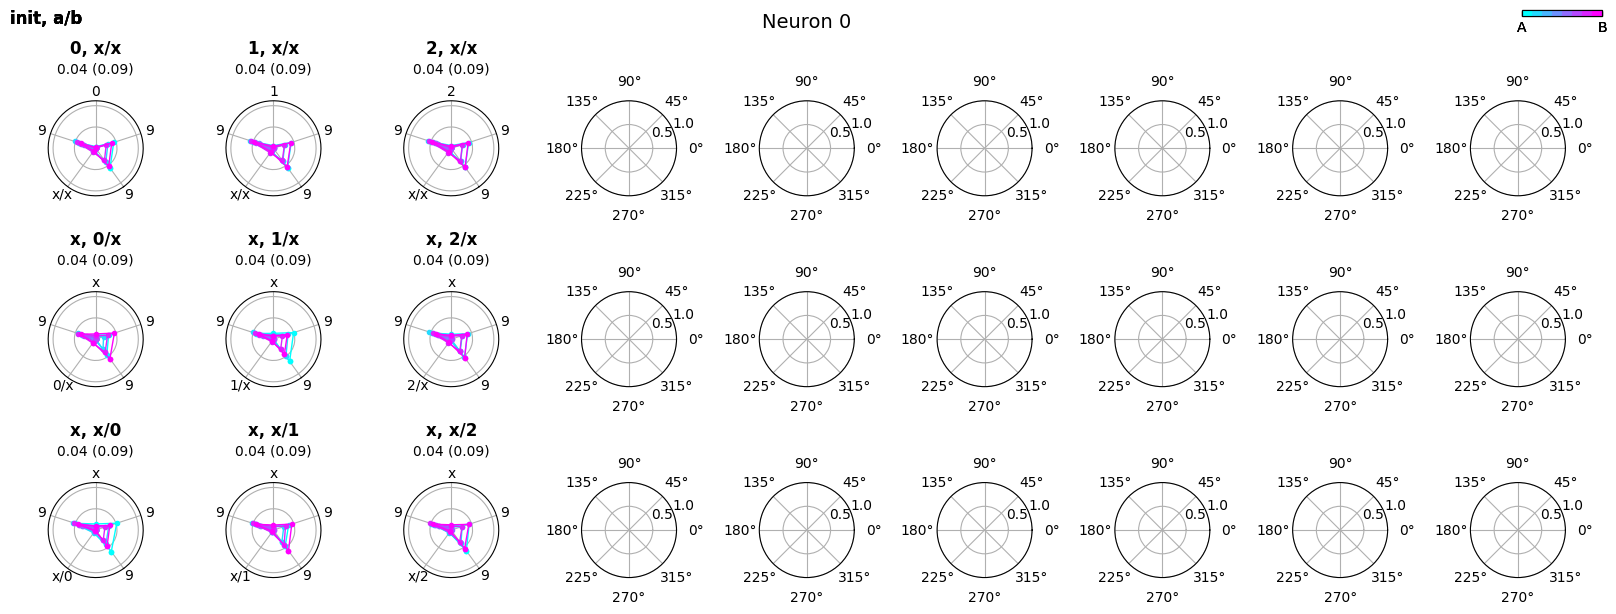

In [5]:
from tqdm import tqdm
from matplotlib.lines import Line2D
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

choices_arg = np.argmax(choices, axis=-1)
choices_arg_trial = np.array_split(choices_arg, choices_arg.shape[-1]//Conf.trial_len, axis=-1)
choices_arg_trial = np.stack(choices_arg_trial, axis=1)

targets_arg = np.argmax(targets, axis=-1)
targets_arg_trial = np.array_split(targets_arg, targets_arg.shape[-1]//Conf.trial_len, axis=-1)
targets_arg_trial = np.stack(targets_arg_trial, axis=1)
 
hidden_trial = np.array_split(hiddens, hiddens.shape[-2]//Conf.trial_len, axis=-2)
hidden_trial = np.stack(hidden_trial, axis=1)

n_neurons = 256
n_p_bins = 8
neur_ids = range(np.minimum(n_neurons, hiddens.shape[-1]))
polar = True
separate_figures = True
overwrite = True
init_step, a_step, b_step, choice_step = 2, 3, 4, 4
# load_dir = '../run_data_1_128_l2_1e6_l2_3e4'

subplot_kw={'projection': 'polar'} if polar else None

bin_edges = np.linspace(1, 0, n_p_bins+1)  # Creates 5 edges for 4 bins
bins = np.digitize(p_A, bin_edges) - 1

cmap = cm.get_cmap('cool', n_p_bins) if n_p_bins > 2 else cm.get_cmap('bwr', n_p_bins) # Get a colormap object

if not separate_figures:
    raise NotImplementedError()
    # # Adjusting figure size based on the number of batches and neurons
    # fig_width = max(10, n_batches)  # Adjust width as needed
    # fig_height = max(20, n_neurons)  # Adjust height as needed
    # fig, axes = plt.subplots(n_neurons, n_batches, figsize=(fig_width, fig_height),
    #                         subplot_kw=subplot_kw, layout='constrained')
else:
    n_col = Conf.port_dim
    n_row = 3
    # Adjusting figure size based on the number of batches and neurons
    fig_width = 16  # Adjust width as needed
    fig_height = 6  # Adjust height as needed
    save_dir = os.path.join(load_dir, 'separate_figs', 'polar' if polar else 'planar', 'mean', 'polar')
    print(save_dir)
    if not os.path.exists(save_dir): os.makedirs(save_dir)

theta = np.linspace(0, 2*np.pi, Conf.trial_len, endpoint=False)
if polar:
    theta = np.append(theta, theta[0])
rotation_angle = (2*np.pi / Conf.trial_len)/2 - np.pi/2

# a_trial_confirmed = np.argmax(p_A, axis=1)
# b_trial_confirmed = np.argmin(p_A, axis=1)
# a_ports = targets_arg_trial[np.arange(len(a_trial_confirmed)), a_trial_confirmed, -1]
# b_ports = targets_arg_trial[np.arange(len(b_trial_confirmed)), b_trial_confirmed, -1]
i_ports = np.argmax(inputs[:,:,:Conf.port_dim], axis=-1)[:, Conf.trial_len-3]
a_ports = np.argmax(inputs[:,:,:Conf.port_dim], axis=-1)[:, Conf.trial_len-2]
b_ports = np.argmax(inputs[:,:,:Conf.port_dim], axis=-1)[:, Conf.trial_len-1]

for k in neur_ids:
    # vmax = np.minimum(Conf.threshold, np.mean(hiddens[:, 5*Conf.trial_len:, k] + 2 * np.std(hiddens[:, 5*Conf.trial_len:, k])))
    vmax = np.percentile(hiddens[:,:,k], 99)
    vmax_ = np.max(hiddens[np.where(anomalous_batches==False)[0], 5*Conf.trial_len:, k])
    vmax_mean = 0
    # print(vmax, vmax_, np.where(hiddens[:, 5*Conf.trial_len:, k] == vmax_))

    if separate_figures:
        fpath = os.path.join(save_dir, str(k) + '.png')
        if not overwrite and os.path.exists(fpath):
            print(f'file {fpath} already exists')
            continue
        fig, axes = plt.subplots(n_row, n_col, figsize=(fig_width, fig_height), subplot_kw=subplot_kw, layout='constrained')
        fig.suptitle(f'Neuron {k}', fontsize=14)
    else:
        raise NotImplementedError()

    for port_id in range(Conf.port_dim):
        for row, step in enumerate([init_step, a_step, b_step]):
            ax = axes[row, port_id]
            if row == 0:
                labels = ['9', '9', str(port_id), '9', 'x/x']
            elif row == 1:
                labels = ['9', '9', 'x', '9', str(port_id) + '/x']
            else:
                labels = ['9', '9', 'x', '9', 'x/' + str(port_id)]

            title = (str(port_id) if row == 0 else 'x') + ', ' + (str(port_id) if row == 1 else 'x') + '/' + (str(port_id) if row == 2 else 'x')
            step_type_trial_mask = inputs_arg_trial[:, :, step] == port_id
            # mask = step_type_trial_mask
            # port_trial_mask = choices_arg_trial[:, :, init_step if step==init_step else choice_step] == port_id
            anomaly_mask = anomalous_batches[:, np.newaxis] * np.ones_like(step_type_trial_mask, dtype=bool)
            # print(step_type_trial_mask.shape, anomaly_mask.shape)
            mask = np.logical_and(np.logical_not(anomaly_mask), step_type_trial_mask)
            # if np.count_nonzero(mask) != 56000:
                # print(k, port_id, row, '!!!')

            # print(['init', 'a', 'b'][row])
            # print('initial mask:', port_id, step, np.count_nonzero(mask))
            for bin_id in range(n_p_bins):
                p_bin_mask = bins == bin_id

                if np.any(p_bin_mask):
                    trial_mask = np.logical_and(mask, p_bin_mask)
                    # print(f'bin {bin_id} {bin_edges[bin_id], bin_edges[bin_id+1]} mask:', port_id, step, np.count_nonzero(trial_mask))

                    trial_idxs = np.where(trial_mask)
                    print(['init', 'a', 'b'][row], bin_id, trial_idxs[0].shape)
                    h = hidden_trial[trial_idxs[0], trial_idxs[1], :, k]
                    h_mean = np.mean(h, axis=0)
                    vmax_mean = np.maximum(np.max(h_mean), vmax_mean)

                    if polar:
                        h_mean = np.append(h_mean, h_mean[0])
                        ax.set_theta_offset(rotation_angle)
                    else:
                        ax.spines['right'].set_visible(False)
                        ax.spines['top'].set_visible(False)        
                    
                    ax.plot(theta, h_mean, linewidth=1, c=cmap(bin_id), marker='o', markersize=3)
                else:
                    pass
                    # print(port_id, step, 'no trials')
                
            ax.set_xticks(theta[:-1] if polar else theta, labels)
            ax.tick_params(axis='x', pad=-4 if polar else 0)  # Adjust pad value as needed
            # ax.set_xticklabels(a_seq.astype(str).tolist(), fontsize=6, pad=-15)  # Adjust pad as needed
            ax.set_yticklabels([])  # Remove y-ticks
            # vlim = np.maximum(np.minimum(vmax, vmax_), 0.1)
            ax.set_ylim([0, vmax])
            # if batch == 0 and not separate_figures:
            #     ax.set_ylabel(f'Neuron {k}', labelpad=20, fontsize=12)
            # if k == 0 or separate_figures:
            ax.set_title(title, fontsize=12, fontweight='bold')
            ax.set_xlabel(f'{vmax:.2f} ({vmax_:.2f})', labelpad=20 if polar else 5, fontsize=10)
            ax.xaxis.set_label_position('top')

        cbar_ax = fig.add_axes([0.947, 0.987, 0.05, 0.01])  # Adjust these values as needed
        cbar = fig.colorbar(cm.ScalarMappable(norm=None, cmap=cmap), cax=cbar_ax, orientation='horizontal')
        # Set the colorbar ticks and labels
        cbar.set_ticks([0, 1])
        cbar.set_ticklabels(['A', 'B'])
        cbar.ax.tick_params(direction='in', pad=3, labelsize=10)

        fig.text(0.002, 0.998, 'init, a/b', fontsize=12, fontweight='bold', ha='left', va='top')   

        fig.savefig(fpath)

    # vlim = vmax_mean
    # for ax in axes.flatten(): 
    #     ax.set_ylim([0, vlim])
    #     ax.set_xlabel(f'{vlim:.2f} ({vmax_:.2f})', labelpad=20 if polar else 5, fontsize=10)

    # for batch in range(np.minimum(n_batches, hiddens.shape[0])):
    #     vmax_batch = np.max(hiddens[batch, 5*Conf.trial_len:, k])
    #     a_idx = np.where(choices_arg_trial[batch, :, -1] == a_ports[batch])[0]
    #     b_idx = np.where(choices_arg_trial[batch, :, -1] == b_ports[batch])[0]
    #     perm = (i_ports[batch], a_ports[batch], b_ports[batch])
        
        # a_seq = choices_arg_trial[batch, a_idx[0], :]
        # b_seq = choices_arg_trial[batch, b_idx[0], :]
        # labels = [str(a_lab) if a_lab == b_lab else str(a_lab) + '/' + str(b_lab) for a_lab, b_lab in zip(a_seq, b_seq)]
    
        # if not separate_figures:
        #     ax = axes[k, batch]
        # else:
        #     ver_idx, hor_idx = perm[0]*(Conf.port_dim) + perm[1], perm[2]
        #     if ver_idx >= axes.shape[0] or hor_idx >= axes.shape[1]:
        #         continue
        #     ax = axes[ver_idx, hor_idx] #axes.flatten()[batch]
        #     ax.set_visible(True)

        # h = hidden_trial[batch, :, :, k]
        # # Assign each probability to a bin
        # bins = np.digitize(p_A[batch, :], bin_edges) - 1
        # for i in range(n_p_bins):
        #     bin_idxs = np.where(bins == i)[0]
#             if len(bin_idxs) > 0:
#                 h_bin = h[bin_idxs, :]
#                 h_bin_mean = np.mean(h_bin, axis=0)

#                 if polar:
#                     h_bin_mean = np.append(h_bin_mean, h_bin_mean[0])
#                     ax.set_theta_offset(rotation_angle)
#                 else:
#                     ax.spines['right'].set_visible(False)
#                     ax.spines['top'].set_visible(False)        
                
#                 ax.plot(theta, h_bin_mean, linewidth=1, c=cmap(i), marker='o', markersize=3)
            
#         ax.set_xticks(theta[:-1] if polar else theta, labels)
#         ax.tick_params(axis='x', pad=-4 if polar else 0)  # Adjust pad value as needed
#         # ax.set_xticklabels(a_seq.astype(str).tolist(), fontsize=6, pad=-15)  # Adjust pad as needed
#         ax.set_yticklabels([])  # Remove y-ticks
#         vlim = np.minimum(vmax, vmax_)
#         ax.set_ylim([0, np.maximum(vlim, 0.1)])
#         if batch == 0 and not separate_figures:
#             ax.set_ylabel(f'Neuron {k}', labelpad=20, fontsize=12)
#         if k == 0 or separate_figures:
#             # ax.set_title(f'Layout {batch}', fontsize=12)
#             ax.set_title(f'{perm[0]}, {perm[1]}/{perm[2]}', fontsize=12, fontweight='bold')
#         ax.set_xlabel(f'{vlim:.2f} ({vmax_batch:.2f})', labelpad=20 if polar else 5, fontsize=10)
#         ax.xaxis.set_label_position('top')

#     if separate_figures:
#         fig.savefig(fpath)
#         plt.close()
# else:
#     fig.savefig(os.path.join(load_dir, 'polar.png' if polar else 'planar.png'))
#     plt.show()
        


In [10]:
for i in range(9,0,-1):
    print(i)

9
8
7
6
5
4
3
2
1


/var/folders/lv/jc4t_z1d75n6dp1c2sbbc9xc0000gn/T/ipykernel_58372/3124446040.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('cool', n_p_bins) if n_p_bins > 2 else cm.get_cmap('bwr', n_p_bins) # Get a colormap object


../run_data_08_256_l2_1e6_l2_3e4/separate_figs/polar/mean/hist_griddy


  0%|          | 0/1 [00:00<?, ?it/s]

0 init 0 (10007,)
[1.9413484e-02 1.3728616e-02 4.6087020e-08 1.5645536e-02 0.0000000e+00] [5.1051499e-03 4.6847425e-03 4.6098971e-06 7.2319624e-03 0.0000000e+00]
0 init 1 (4343,)
[2.0259019e-02 1.3543957e-02 2.4758072e-06 1.4818380e-02 0.0000000e+00] [7.1518361e-03 5.8005839e-03 5.4686821e-05 7.2156605e-03 0.0000000e+00]
0 init 2 (2926,)
[0.02427654 0.01974983 0.0002617  0.01598137 0.        ] [0.00705176 0.00588042 0.00092158 0.00722053 0.        ]
0 init 3 (1589,)
[0.02748414 0.01744602 0.00012968 0.01458744 0.        ] [0.00645018 0.00559465 0.00072749 0.00689643 0.        ]
0 init 4 (2252,)
[2.8493129e-02 1.6799789e-02 4.5533950e-05 1.4583284e-02 0.0000000e+00] [0.00460715 0.00400358 0.00027268 0.00679917 0.        ]
0 init 5 (2482,)
[2.1814590e-02 1.4209776e-02 1.6254076e-03 1.9456113e-02 7.5782800e-06] [0.00491101 0.0050421  0.00316249 0.00856922 0.00013238]
0 init 6 (2696,)
[2.1650564e-02 1.4030490e-02 1.6529914e-03 1.9283993e-02 4.3500431e-06] [5.1879589e-03 5.3727916e-03 3.230

100%|██████████| 1/1 [00:10<00:00, 10.25s/it]


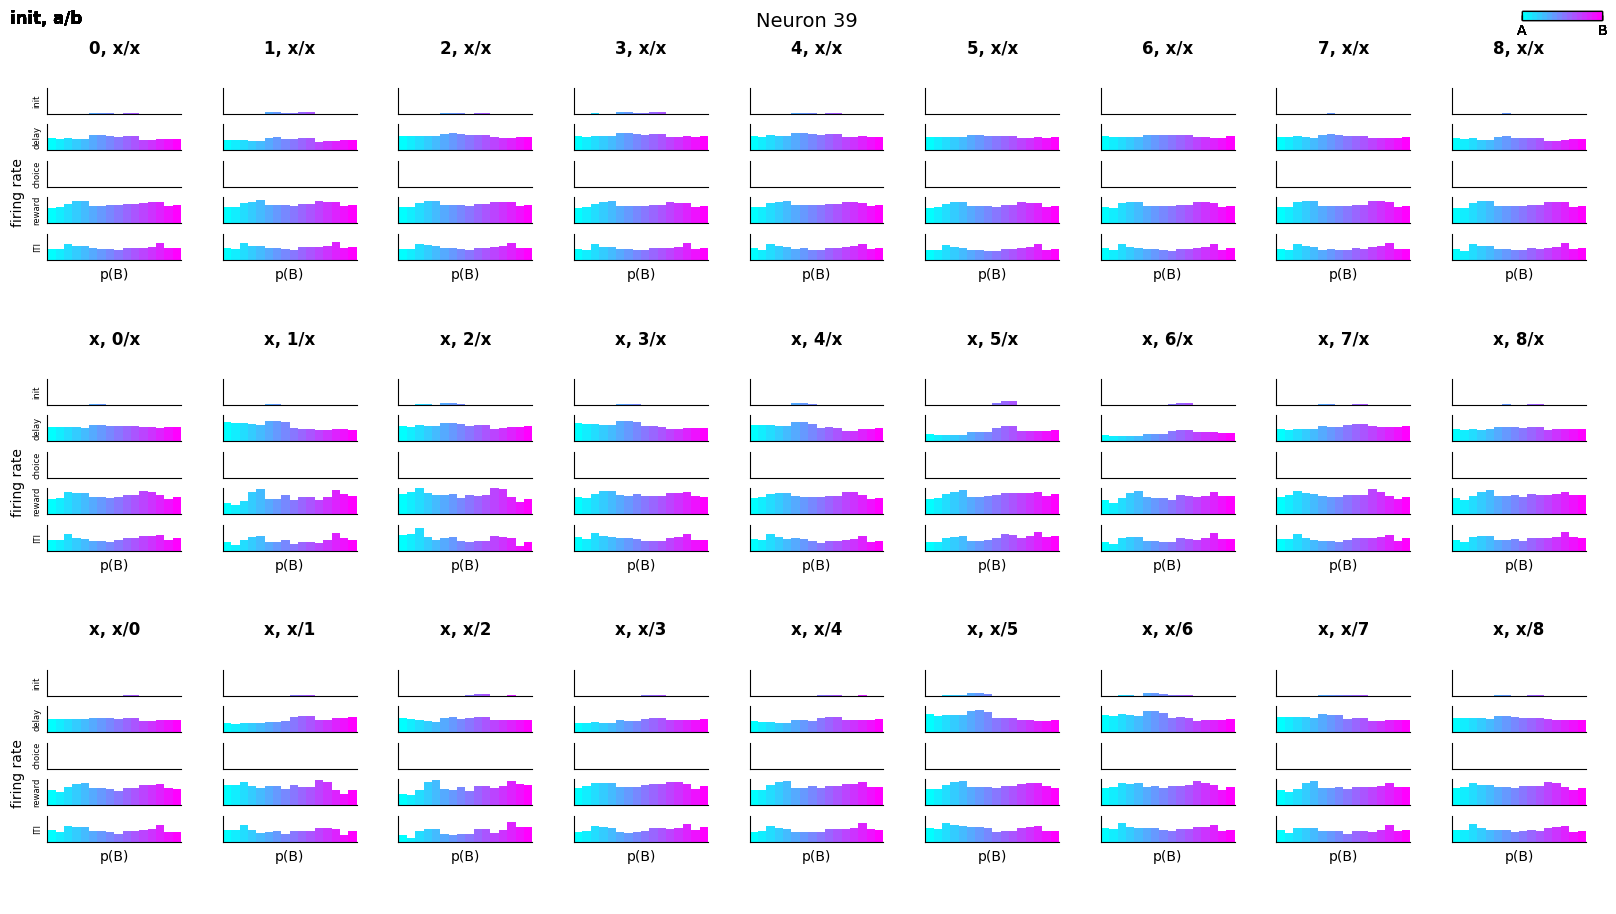

In [12]:
from tqdm import tqdm
from matplotlib.lines import Line2D
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

choices_arg = np.argmax(choices, axis=-1)
choices_arg_trial = np.array_split(choices_arg, choices_arg.shape[-1]//Conf.trial_len, axis=-1)
choices_arg_trial = np.stack(choices_arg_trial, axis=1)

targets_arg = np.argmax(targets, axis=-1)
targets_arg_trial = np.array_split(targets_arg, targets_arg.shape[-1]//Conf.trial_len, axis=-1)
targets_arg_trial = np.stack(targets_arg_trial, axis=1)
 
hidden_trial = np.array_split(hiddens, hiddens.shape[-2]//Conf.trial_len, axis=-2)
hidden_trial = np.stack(hidden_trial, axis=1)

n_neurons = 256
n_p_bins = 16
# neur_ids = range(np.minimum(n_neurons, hiddens.shape[-1]))
neur_ids = [39]
polar = True
separate_figures = True
overwrite = True
init_step, a_step, b_step, choice_step = 2, 3, 4, 4
# load_dir = '../run_data_1_128_l2_1e6_l2_3e4'


bin_edges = np.linspace(1, 0, n_p_bins+1)  # Creates 5 edges for 4 bins
bins = np.digitize(p_A, bin_edges) - 1

cmap = cm.get_cmap('cool', n_p_bins) if n_p_bins > 2 else cm.get_cmap('bwr', n_p_bins) # Get a colormap object

if not separate_figures:
    raise NotImplementedError()
else:
    n_col = Conf.port_dim
    n_row = 3
    # Adjusting figure size based on the number of batches and neurons
    fig_width = 16  # Adjust width as needed
    fig_height = 9  # Adjust height as needed
    save_dir = os.path.join(load_dir, 'separate_figs', 'polar' if polar else 'planar', 'mean', 'hist_griddy')
    print(save_dir)
    if not os.path.exists(save_dir): os.makedirs(save_dir)

theta = np.linspace(0, 2*np.pi, Conf.trial_len, endpoint=False)
if polar:
    theta = np.append(theta, theta[0])
rotation_angle = (2*np.pi / Conf.trial_len)/2 - np.pi/2

# a_trial_confirmed = np.argmax(p_A, axis=1)
# b_trial_confirmed = np.argmin(p_A, axis=1)
# a_ports = targets_arg_trial[np.arange(len(a_trial_confirmed)), a_trial_confirmed, -1]
# b_ports = targets_arg_trial[np.arange(len(b_trial_confirmed)), b_trial_confirmed, -1]
i_ports = np.argmax(inputs[:,:,:Conf.port_dim], axis=-1)[:, Conf.trial_len-3]
a_ports = np.argmax(inputs[:,:,:Conf.port_dim], axis=-1)[:, Conf.trial_len-2]
b_ports = np.argmax(inputs[:,:,:Conf.port_dim], axis=-1)[:, Conf.trial_len-1]

for k in tqdm(neur_ids):
    # vmax = np.minimum(Conf.threshold, np.mean(hiddens[:, 5*Conf.trial_len:, k] + 2 * np.std(hiddens[:, 5*Conf.trial_len:, k])))
    vmax = np.percentile(hiddens[:,:,k], 99)
    vmax_ = np.max(hiddens[np.where(anomalous_batches==False)[0], 5*Conf.trial_len:, k])
    vmax_mean = 0
    # print(vmax, vmax_, np.where(hiddens[:, 5*Conf.trial_len:, k] == vmax_))

    if separate_figures:
        fpath = os.path.join(save_dir, str(k) + '.png')
        if not overwrite and os.path.exists(fpath):
            print(f'file {fpath} already exists')
            continue
        fig, axes = plt.subplots(n_row, n_col, figsize=(fig_width, fig_height), layout='constrained')
        fig.suptitle(f'Neuron {k}', fontsize=14)
    else:
        raise NotImplementedError()

    for port_id in range(Conf.port_dim):
        for row, step in enumerate([init_step, a_step, b_step]):
            ax = axes[row, port_id]
            ax.xaxis.set_visible(False)
            # ax.yaxis.set_visible(False)
            ax.set_yticks([])
            ax.set_xticks([])
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
            if port_id == 0:
                ax.set_ylabel('firing rate')
            # if row == n_row - 1:
            #     ax.set_xlabel('p')

            title = (str(port_id) if row == 0 else 'x') + ', ' + (str(port_id) if row == 1 else 'x') + '/' + (str(port_id) if row == 2 else 'x')
            ax.set_title(title, fontsize=12, fontweight='bold')

            step_type_trial_mask = inputs_arg_trial[:, :, step] == port_id
            # mask = step_type_trial_mask
            # port_trial_mask = choices_arg_trial[:, :, init_step if step==init_step else choice_step] == port_id
            anomaly_mask = anomalous_batches[:, np.newaxis] * np.ones_like(step_type_trial_mask, dtype=bool)
            # print(step_type_trial_mask.shape, anomaly_mask.shape)
            mask = np.logical_and(np.logical_not(anomaly_mask), step_type_trial_mask)

            bin_heights = np.zeros((Conf.trial_len, n_p_bins))
            for bin_id in range(n_p_bins):
                p_bin_mask = bins == bin_id

                if np.any(p_bin_mask):
                    trial_mask = np.logical_and(mask, p_bin_mask)

                    trial_idxs = np.where(trial_mask)
                    print(port_id, ['init', 'a', 'b'][row], bin_id, trial_idxs[0].shape)

                    h = hidden_trial[trial_idxs[0], trial_idxs[1], :, k]
                    h_mean = np.mean(h, axis=0)
                    print(h_mean, np.std(h, axis=0))
                    bin_heights[:, bin_id] = np.roll(h_mean, shift=-2)
            # q: how do I make 5 axes within main axis?

            # Parameters for inner axes
            inner_ax_width = "100%"  # Example width
            inner_ax_height = "10%" # Example height
            inner_ax_x = "65%"      # Example X-position
            inner_ax_y = "65%"      # Example Y-position

            y_shift = (1 - 0.3)/Conf.trial_len
            # Create and plot in inner axes
            for i in range(Conf.trial_len):
                inner_ax = inset_axes(ax, width=inner_ax_width, height=inner_ax_height, 
                                      loc=2, bbox_to_anchor=(0.1, -0.1-y_shift*i, 0.8, 1),
                                      bbox_transform=ax.transAxes, borderpad=0)

                # Example plotting in inner_ax
                # inner_ax.plot([0, 1], [0, 1], 'r-') 
                x = np.flip(bin_edges)
                # inner_ax.hist(x[:-1], x, weights=bin_heights[i,:], color=cmap(np.arange(n_p_bins)))
                # Now plot each bar with its respective color
                centres = (x[:-1] + x[1:]) / 2
                for j, height in enumerate(bin_heights[i, :]):
                    inner_ax.bar(centres[j], height, color=cmap(j), width=1/n_p_bins)

                inner_ax.set_ylim([0, vmax])
                inner_ax.set_xlim([0, 1])
                
                # Turn off tick labels
                if port_id == 0:
                    inner_ax.set_ylabel(['init', 'delay', 'choice', 'reward', 'ITI'][i], fontsize=6)
                inner_ax.set_yticks([])
                inner_ax.spines['right'].set_visible(False)
                inner_ax.spines['top'].set_visible(False)
                # inner_ax.spines['left'].set_visible(False)
                if (i == Conf.trial_len - 1):# and (row == n_row - 1):
                    # inner_ax.set_xticks([0, 1], ['A', 'B'])
                    inner_ax.set_xticks([0.5], ['p(B)'])
                    inner_ax.tick_params(axis='x', which='both', length=0, pad=6)
                    # inner_ax.set_xlabel('p(B)', fontsize=6)
                else:
                    inner_ax.set_xticks([])

                # inner_ax.set_title(f'step {i}', fontsize=8)

        # Parameters for the colorbar axis (left, bottom, width, height)
        cbar_ax = fig.add_axes([0.947, 0.987, 0.05, 0.01])  # Adjust these values as needed
        cbar = fig.colorbar(cm.ScalarMappable(norm=None, cmap=cmap), cax=cbar_ax, orientation='horizontal')
        # Set the colorbar ticks and labels
        cbar.set_ticks([0, 1])
        cbar.set_ticklabels(['A', 'B'])
        cbar.ax.tick_params(direction='in', pad=3, labelsize=10)

        fig.text(0.002, 0.998, 'init, a/b', fontsize=12, fontweight='bold', ha='left', va='top')   

        fig.savefig(fpath)              
                
                

In [67]:
vmax_ = np.max(hiddens[np.where(anomalous_batches==False)[0], 5*Conf.trial_len:, k])

[113] [4979] 0.06524853
[189 366] [4016 4017 4018 ... 4976 4977 4978] 5.0
(1, 5000)
0.0037729144
(array([189, 189, 189, ..., 366, 366, 366]), array([4016, 4017, 4018, ..., 4976, 4977, 4978]))
0.03459681555628777
0.045196336694061735


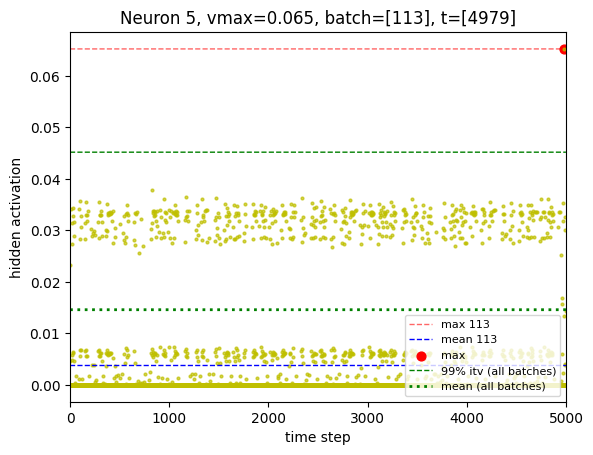

In [168]:
k=5
vmax_no_anom = np.max(hiddens[np.where(anomalous_batches==False)[0], 5*Conf.trial_len:, k])
idx_with_no_anom_max, t_no_anom = np.where(hiddens[:,:, k] == vmax_no_anom)

vmax_anom = np.max(hiddens[:, 5*Conf.trial_len:, k])
idx_with_anom_max, t_anom = np.where(hiddens[:,:, k] == vmax_anom)
idx_with_anom_max = np.unique(idx_with_anom_max)

print(idx_with_no_anom_max, t_no_anom, vmax_no_anom)
print(idx_with_anom_max, t_anom, vmax_anom)

hids = hiddens[idx_with_no_anom_max, :, k]
print(hids.shape)
dotteds = vmax_no_anom * np.ones_like(hids)
means = np.mean(hids, axis=-1) * np.ones_like(hids)
print(means[0,0])
fig = plt.figure()
[plt.plot(d, c='r', alpha=0.6, linestyle='--', linewidth=1, label=f'max {b}') for d, b in zip(dotteds, idx_with_no_anom_max)]
[plt.plot(h, c='y', linewidth=0, marker='o', markersize=2, alpha=0.7) for h in hids]
[plt.plot(m, c='b', linestyle='--', linewidth=1, label=f'mean {b}') for m, b in zip(means, idx_with_no_anom_max)]
[plt.scatter(t_no_anom, h[t_no_anom], marker='o', c='r', s=40, label='max') for h in hids]
print(np.where(hiddens[:,:, k] == np.max(hiddens[:,:,k])))
plt.title(f'Neuron {k}, vmax={vmax_:.3f}, batch={idx_with_no_anom_max}, t={t_no_anom}', fontsize=12)
plt.ylabel('hidden activation')
plt.xlabel('time step')
plt.xlim([0, hiddens.shape[1]])

# Assuming `data` is your dataset
lower_bound = np.percentile(hids[0], 0.5)
itv = 99
upper_bound_ = np.percentile(hids[0], 99)
print(upper_bound_)
upper_bound = np.percentile(hiddens[:,:,k], 99)
mean = np.mean(hiddens[:,:,k])
print(upper_bound)
uppers = upper_bound * np.ones_like(hids)
means = mean * np.ones_like(hids)
[plt.plot(u, c='g', linestyle='--', linewidth=1, label=f'{itv}% itv (all batches)') for u in uppers]
[plt.plot(m, c='g', linestyle='dotted', linewidth=2, label='mean (all batches)') for m in means]

plt.legend(fontsize=8, loc='lower right');


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
import mpl_toolkits.axisartist.floating_axes as floating_axes
from mpl_toolkits.axisartist.grid_finder import DictFormatter

# Given data
data = np.random.rand(5, 10)

# Base polar plot
fig = plt.figure()
ax = fig.add_subplot(111, polar=True)

# Define the number of bins for the histograms
num_bins = 4

bin_edges = np.linspace(0, 1, num_bins+1, endpoint=True)  # Creates 5 edges for 4 bins

# Plot histograms on separate Cartesian axes
for i, d in enumerate(data):
    hist, _ = np.histogram(d, bins=num_bins)
    # Define the position and rotation of the Cartesian axis
    angle = i * (360 / len(data))
    grid_helper = floating_axes.GridHelperCurveLinear(
        Affine2D().rotate_deg(angle),
        extremes=(0, 10, bin_edges[0], bin_edges[-1]),  # x from 0 to max count, y from bin min to max
        grid_locator1=None,
        grid_locator2=None,
        tick_formatter1=DictFormatter({}),
        tick_formatter2=DictFormatter({})
    )

    # Create a floating axis at the origin of the polar plot
    ax_hist = floating_axes.FloatingSubplot(fig, 111, grid_helper=grid_helper)
    ax_hist.set_anchor('N')
    fig.add_subplot(ax_hist)
    
    # Apply the rotation and translation to align with the spoke
    tr_rotate = Affine2D().rotate_deg_around(0, 0, angle)
    ax_hist.set_transform(tr_rotate + ax.transData)

    # Plot the histogram on the Cartesian axis
    ax_hist.hist(d, bins=bin_edges, orientation='horizontal', alpha=0.5)

# Show the plot
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.projections import PolarAxes
import mpl_toolkits.axisartist.floating_axes as floating_axes
from mpl_toolkits.axisartist.grid_finder import MaxNLocator

# Given data
data = np.random.rand(2, 10)

# Base polar plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, polar=True)

# Define the number of bins for the histograms
num_bins = 4
bin_edges = np.linspace(0, 1, num_bins + 1, endpoint=True)

# Create separate axes for each histogram
for i, d in enumerate(data):
    hist, _ = np.histogram(d, bins=bin_edges)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Set up the floating axis
    tr_rotate = Affine2D().rotate_around(0, 0, -np.degrees(theta[i]))
    tr = tr_rotate + PolarAxes.PolarTransform()
    
    # Create a floating axis for the histogram
    grid_helper = floating_axes.GridHelperCurveLinear(tr,
                                                      extremes=(0, max(hist), bin_edges[0], bin_edges[-1]),
                                                      grid_locator1=MaxNLocator(nbins=4),
                                                      grid_locator2=MaxNLocator(nbins=num_bins))
    
    ax_hist = floating_axes.FloatingSubplot(fig, 111, grid_helper=grid_helper)
    fig.add_subplot(ax_hist)

    # # Plot the histogram on the Cartesian axis
    # for center, val in zip(bin_centers, hist):
    #     bar = plt.Rectangle((center, 0), width=bin_edges[1] - bin_edges[0], height=val, 
    #                         transform=ax_hist.get_aux_transform(), alpha=0.5)
    #     ax_hist.add_patch(bar)

# Set the title and display the plot
ax.set_title("Histograms along spokes")
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Given data
data = np.random.rand(5, 10)

# Base polar plot
fig, ax = plt.figure(figsize=(8, 8)), plt.subplot(111, polar=True)

# Define the number of bins for the histograms
num_bins = 4

# Calculate the bin edges and bin width
bin_edges = np.linspace(0, 1, num_bins+1, endpoint=True)

# Plot histograms on separate Cartesian axes
for i, d in enumerate(data):
    hist, _ = np.histogram(d, bins=bin_edges)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Define the position and rotation of the Cartesian axis
    angle = i * (2 * np.pi / len(data))

    # Width of each bar (in radians)
    bar_width = (2 * np.pi) / (len(data) * num_bins)

    # Plot the histogram on the polar axis
    for count, bin_center in zip(hist, bin_centers):
        # The radial distance for the bar
        r = bin_center
        
        # The height of each bar (radially outward)
        bar_height = count / np.max(hist) * 0.2  # scale height to max count for visibility
        
        # Create a rectangle patch (bar) for the histogram
        rect = Rectangle((angle, r), bar_width, bar_height, 
                         transform=ax.transData._b, 
                         color=plt.cm.viridis(bin_center), alpha=0.5)
        
        # Rotate and translate the rectangle to align with the spoke
        tr = Affine2D().rotate_around(0, 0, angle) + ax.transData
        rect.set_transform(tr)
        
        # Add the rectangle to the plot
        ax.add_patch(rect)

# Show the plot
plt.show()


In [ ]:
# Set up the polar plot
fig = plt.figure()
ax = fig.add_subplot(111, polar=True)

# Create a rectangle patch with the correct orientation and size
rect = patches.Rectangle((theta[i], bottom), width=0.2, height=6, 
                            transform=ax.transData._b, color=plt.cm.viridis(bin_edges[j]/max_radius), 
                            alpha=0.5)

# Rotate the rectangle to align with the spoke
t = plt.matplotlib.transforms.Affine2D().rotate(theta[i]) + ax.transData
rect.set_transform(t)

# Add the rectangle to the plot
ax.add_patch(rect)

In [ ]:
# Assign each probability to a bin
n_p_bins = 5
bin_edges = np.linspace(0, 1, n_p_bins+1)  # Creates 5 edges for 4 bins

# print(a_idx)
for batch in range(10):
    print('\nbatch', batch)
    bins = np.digitize(p_A[batch, :], bin_edges) - 1
    a_idx = np.where(choices_arg_trial[batch, :, -1] == a_ports[batch])[0]
    b_idx = np.where(choices_arg_trial[batch, :, -1] == b_ports[batch])[0]
    for i in range(n_p_bins):
        bin_idxs = set(np.where(bins == i)[0])
        # print(bin_idxs)
        print(i, bin_idxs.issubset(set(a_idx)), bin_idxs.issubset(set(b_idx)))


# q: how to check if all bin_idxs are in a_idx?
#
    
    # if len(bin_idxs) > 0:
    #     h_bin = h[bin_idxs, :]
    #     h_bin_mean = np.mean(h_bin, axis=0)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Number of rows and columns
nrows, ncols = 6, 2
every_n = 2  # Draw line after every 2 rows

# Create subplots
fig, axs = plt.subplots(nrows, ncols, figsize=(10, 8))

# Example plotting
for i in range(nrows * ncols):
    axs[i // ncols, i % ncols].plot([0, 1], [0, 1])  # Example plot

# Draw horizontal lines across the figure
for i in range(1, nrows // every_n):
    # Calculate the y position in figure coordinates
    line_y = (nrows - i * every_n) / nrows
    # Create a line at the desired y position that spans the width of the figure
    line = Line2D([0, 1], [line_y, line_y], transform=fig.transFigure, color="black", linewidth=2)
    fig.add_artist(line)

plt.tight_layout()
plt.show()


In [ ]:
n_batches = 14
n_col = 8
n_row = int(np.ceil((n_batches) / n_col))
# Adjusting figure size based on the number of batches and neurons
fig_width = 8  # Adjust width as needed
fig_height = max(2, n_row)  # Adjust height as needed
all_figs = [plt.subplots(n_row, n_col, figsize=(fig_width, fig_height),
                        subplot_kw=subplot_kw, layout='constrained') for i in range(n_neurons)]
for fig, axes in all_figs:
    # Flatten the axes array and make the unnecessary ones invisible
    for ax in axes.flatten()[n_batches:]:
        ax.set_visible(False)

In [ ]:
a_trial_confirmed = np.argmax(p_A, axis=1)
b_trial_confirmed = np.argmin(p_A, axis=1)
a_ports = targets_arg_trial[np.arange(len(a_trial_confirmed)), a_trial_confirmed, -1]
b_ports = targets_arg_trial[np.arange(len(b_trial_confirmed)), b_trial_confirmed, -1]
print(a_ports)
print(b_ports)

x = np.argmax(inputs[:,:,:Conf.port_dim], axis=-1)[:, Conf.trial_len-2]
y = np.argmax(inputs[:,:,:Conf.port_dim], axis=-1)[:, Conf.trial_len-1]

print(x)
print(y)

In [ ]:
vmaxs_, vmaxs = [], []
for k in range(np.minimum(n_neurons, hiddens.shape[-1])):
    vmax_ = np.mean(hiddens[:, 2*Conf.trial_len:, k]) + 2 * np.std(hiddens[:, 2*Conf.trial_len:, k])
    vmax = np.max(hiddens[:, :, k])

    vmaxs_.append(vmax_)
    vmaxs.append(vmax)

plt.plot(vmaxs_)
plt.plot(vmaxs)

print(vmaxs_[32-4], vmaxs[32-4])


In [ ]:
from copy import copy

batch = 0
k = 2

a_idx = np.where(choices_arg_trial[batch, :, -1] == a_ports[batch])[0]
b_idx = np.where(choices_arg_trial[batch, :, -1] == b_ports[batch])[0]

# for k in range(np.minimum(n_neurons, hiddens.shape[-1])):
vmax = np.mean(hiddens[:, 5*Conf.trial_len:, k]) + 2 * np.std(hiddens[:, 5*Conf.trial_len:, k])
vmax_ = np.max(hiddens[batch, 5*Conf.trial_len:, k])
ax = axes[k, batch]

h = hidden_trial[batch, :, :, k]
# h_a = h[a_idx, :]
h_a = np.ones_like(h) * np.nan
h_a[a_idx, :] = h[a_idx, :]
h_b = np.ones_like(h) * np.nan
h_b[b_idx, :] = h[b_idx, :]
r = inputs[batch, ::Conf.trial_len, Conf.port_dim] == 1
h_a_r = copy(h_a)
h_a_r[r, :] = np.nan
h_b_r = copy(h_b)
h_b_r[r, :] = np.nan
# h_b = h[b_idx, :]

for i in range(Conf.trial_len):
    plt.figure()
    plt.plot(h_a[:, i])
    plt.plot(h_b[:, i])
    plt.plot(h_a_r[:, i], marker='o', c='g')
    plt.plot(h_b_r[:, i], marker='o', c='g')
    plt.title(i)
    plt.xlim([0, 100])
    plt.xlabel('trial')